##### Copyright 2018 The TF-Agents Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TF-Agent を使用した Deep Q Network のトレーニング

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/agents/tutorials/1_dqn_tutorial"><img src="https://www.tensorflow.org/images/tf_logo_32px.png"> TensorFlow.orgで表示</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/agents/tutorials/1_dqn_tutorial.ipynb">     <img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colabで実行</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/agents/tutorials/1_dqn_tutorial.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub でソースを表示{</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/agents/tutorials/1_dqn_tutorial.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロード/a0}</a></td>
</table>

## はじめに


この例は、Cartpole環境でTF-Agentsライブラリを使用して[ DQN（Deep Q Networks）](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf)エージェントをトレーニングする方法を示しています。

![Cartpole environment](https://raw.githubusercontent.com/tensorflow/agents/master/docs/tutorials/images/cartpole.png)

ここでは、トレーニング、評価、データ収集のための強化学習（RL）パイプラインのすべてのコンポーネントについて説明します。

このコードをライブで実行するには、上の [Google Colabで実行] リンクをクリックしてください。


## セットアップ

以下の依存関係をインストールしていない場合は、実行します。

In [ ]:
!sudo apt-get install -y xvfb ffmpeg
!pip install -q 'gym==0.10.11'
!pip install -q 'imageio==2.4.0'
!pip install -q PILLOW
!pip install -q 'pyglet==1.3.2'
!pip install -q pyvirtualdisplay
!pip install -q tf-agents

In [1]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2022-06-23 16:11:51.996394: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-23 16:11:52.187326: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-06-23 16:11:52.187349: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4252465192787916834
 xla_global_id: -1]

In [1]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

In [2]:
tf.compat.v1.enable_v2_behavior()

# Set up a virtual display for rendering OpenAI gym environments.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

In [3]:
tf.version.VERSION

'2.9.1'

## ハイパーパラメータ

In [4]:
num_iterations = 20000 # @param {type:"integer"}

initial_collect_steps = 1000  # @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

## 環境

強化学習（RL）では、環境はタスクまたは解決すべき問題を表します。標準環境は、`tf_agents.environments`スイートを使用して TF-Agent で作成できます。TF-Agent には、OpenAI Gym、Atari、DM Control などのソースから環境を読み込むためのスイートがあります。

OpenAI Gym スイートから CartPole 環境を読み込みます。 

In [5]:
env_name = 'CartPole-v0'
env = suite_gym.load(env_name)

この環境をレンダリングして、どのように見えるかを確認できます。台車の上に自由に振り動く棒を立て、その棒が倒れないように台車を左右に動かすことが目標です。

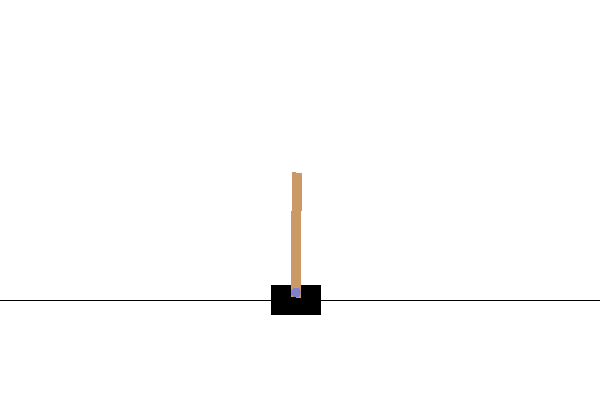

In [6]:
#@test {"skip": true}
env.reset()
PIL.Image.fromarray(env.render())

`environment.step`メソッドは、環境内で`action`を取り、環境の次の観測と行動の報酬を含む`TimeStep`タプルを返します。

`time_step_spec()`メソッドは、`TimeStep`タプルの仕様を返します。その`observation`属性は、観測の形状、データ型、および許容値の範囲を示します。`reward`属性は、報酬についての同じ詳細を示します。


In [7]:
print('Observation Spec:')
print(env.time_step_spec().observation)

Observation Spec:
BoundedArraySpec(shape=(4,), dtype=dtype('float32'), name='observation', minimum=[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], maximum=[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38])


In [8]:
print('Reward Spec:')
print(env.time_step_spec().reward)

Reward Spec:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')


`action_spec()`メソッドは、有効な行動の形状、データタイプ、および許容値を返します。

In [9]:
print('Action Spec:')
print(env.action_spec())

Action Spec:
BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=1)


CartPole 環境では

- `observation`は以下の 4 つの float 型の配列です。
    - 台車の位置と速度
    - 棒の角度位置と速度
- `reward`はスカラーの浮動小数点値です
- `action`は可能な値が 2 つだけのスカラー整数です。
    - `0` — 「左に移動」
    - `1` — 「右に移動」


In [10]:
time_step = env.reset()
print('Time step:')
print(time_step)

action = np.array(1, dtype=np.int32)

next_time_step = env.step(action)
print('Next time step:')
print(next_time_step)

Time step:
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([-0.01561419, -0.0394837 , -0.02656266,  0.0020255 ], dtype=float32),
 'reward': array(0., dtype=float32),
 'step_type': array(0, dtype=int32)})
Next time step:
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([-0.01640386,  0.15600893, -0.02652215, -0.2989185 ], dtype=float32),
 'reward': array(1., dtype=float32),
 'step_type': array(1, dtype=int32)})


通常、2 つの環境（トレーニング用、評価用）のみがインスタンス化されます。 

In [11]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

CartPole 環境は、ほとんどの環境と同様に純粋な Python で記述されています。これは、`TFPyEnvironment`ラッパーを使用して TensorFlow に変換されます。

従来の環境の API は Numpy 配列を使用します。`TFPyEnvironment`は、これらを`Tensors`に変換して、Tensorflow エージェントおよびポリシーとの互換性を確保します。


In [12]:
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

## エージェント

RL問題の解決に使用されるアルゴリズムは、`Agent`で表されます。TF-Agent は、以下を含むさまざまな`Agents`の標準実装を提供します。

- [DQN](https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf)（本チュートリアルで使用）
- [REINFORCE](http://www-anw.cs.umass.edu/~barto/courses/cs687/williams92simple.pdf)
- [DDPG](https://arxiv.org/pdf/1509.02971.pdf)
- [TD3](https://arxiv.org/pdf/1802.09477.pdf)
- [PPO](https://arxiv.org/abs/1707.06347)
- [SAC](https://arxiv.org/abs/1801.01290)

DQN エージェントは、個別の行動領域がある任意の環境で使用できます。

DQN エージェントの中心にあるのが`QNetwork`です。これは、環境から観察を得て、すべての行動の`QValues`（予期される戻り値）を予測する方法を学習するニューラルネットワークモデルです。

`tf_agents.networks.q_network`を使用して`QNetwork`を作成し、`observation_spec`、`action_spec`、およびモデルの非表示レイヤーの数とサイズを表すタプルを渡します。


In [13]:
fc_layer_params = (100,)

q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

`tf_agents.agents.dqn.dqn_agent`を使用して`DqnAgent`をインスタンス化します。`time_step_spec`、`action_spec`、および QNetwork に加えて、エージェントコンストラクタにもオプティマイザ（この場合、`AdamOptimizer`）、損失関数、および整数ステップカウンタが必要です。

In [14]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

2022-06-23 14:54:52.771821: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-23 14:54:52.938290: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-06-23 14:54:52.938313: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


## ポリシー

ポリシーは、エージェントが環境で行動する方法を定義します。通常、強化学習の目標は、ポリシーが望ましい結果を生成するまで、基礎となるモデルをトレーニングすることです。

このチュートリアルでは

- 望ましい結果は、台車の上の棒が倒れないようにバランスを保つことです。
- ポリシーは、`time_step`観測ごとに行動（左または右）を返します。

エージェントには 2 つのポリシーが含まれています。

- `agent.policy` — 評価とデプロイに使用される主なポリシー。
- `agent.collect_policy` — データ収集に使用される補助的なポリシー。


In [15]:
eval_policy = agent.policy
collect_policy = agent.collect_policy

ポリシーはエージェントとは無関係に作成できます。たとえば、`tf_agents.policies.random_tf_policy`を使用して、各`time_step`の行動をランダムに選択するポリシーを作成できます。

In [16]:
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

ポリシーから行動を取得するには、`policy.action(time_step)`メソッドを呼び出します。`time_step`には、環境からの観測が含まれています。このメソッドは、3 つのコンポーネントを持つ名前付きタプルである`PolicyStep`を返します。

- `action` — 実行する行動（ここでは`0`または`1`)
- `state` — ステートフルポリシー（RNNベース）に使用
- `info` — 行動のログ確率などの補助データ

In [17]:
example_environment = tf_py_environment.TFPyEnvironment(
    suite_gym.load('CartPole-v0'))

In [18]:
time_step = example_environment.reset()

In [19]:
random_policy.action(time_step)

PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int64, numpy=array([0])>, state=(), info=())

## 指標と評価

ポリシーの評価に使用される最も一般的な指標は、平均リターンです。リターンは、エピソードの環境でポリシーを実行中に取得した報酬の合計です。エピソードは何回か実行され、平均リターンが生成されます。

次の関数は、ポリシー、環境、およびエピソードの数を指定して、ポリシーの平均リターンを計算します。


In [20]:
#@test {"skip": true}
def compute_avg_return(environment, policy, num_episodes=10):

  total_return = 0.0
  for _ in range(num_episodes):

    time_step = environment.reset()
    episode_return = 0.0

    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = environment.step(action_step.action)
      episode_return += time_step.reward
    total_return += episode_return

  avg_return = total_return / num_episodes
  return avg_return.numpy()[0]


# See also the metrics module for standard implementations of different metrics.
# https://github.com/tensorflow/agents/tree/master/tf_agents/metrics

この計算を`random_policy`で実行すると、環境のベースラインパフォーマンスが示されます。

In [21]:
compute_avg_return(eval_env, random_policy, num_eval_episodes)

23.7

## 再生バッファ

再生バッファは、環境から収集されたデータを追跡します。このチュートリアルでは最も一般的な`tf_agents.replay_buffers.tf_uniform_replay_buffer.TFUniformReplayBuffer`を使用します。

コンストラクタは、収集するデータの仕様を必要とします。これは、`collect_data_spec`メソッドを使用してエージェントから入手できます。バッチサイズと最大バッファ長も必要です。


In [22]:
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_max_length)

ほとんどのエージェントの場合、`collect_data_spec`は、`Trajectory`と呼ばれる名前付きタプルであり、観測、行動、報酬、およびその他の要素の仕様が含まれています。

In [23]:
agent.collect_data_spec

Trajectory(
{'action': BoundedTensorSpec(shape=(), dtype=tf.int64, name='action', minimum=array(0), maximum=array(1)),
 'discount': BoundedTensorSpec(shape=(), dtype=tf.float32, name='discount', minimum=array(0., dtype=float32), maximum=array(1., dtype=float32)),
 'next_step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type'),
 'observation': BoundedTensorSpec(shape=(4,), dtype=tf.float32, name='observation', minimum=array([-4.8000002e+00, -3.4028235e+38, -4.1887903e-01, -3.4028235e+38],
      dtype=float32), maximum=array([4.8000002e+00, 3.4028235e+38, 4.1887903e-01, 3.4028235e+38],
      dtype=float32)),
 'policy_info': (),
 'reward': TensorSpec(shape=(), dtype=tf.float32, name='reward'),
 'step_type': TensorSpec(shape=(), dtype=tf.int32, name='step_type')})

In [24]:
agent.collect_data_spec._fields

('step_type',
 'observation',
 'action',
 'policy_info',
 'next_step_type',
 'reward',
 'discount')

## データ収集

次に、環境でランダムポリシーを数ステップ実行し、データを再生バッファに記録します。

In [25]:
#@test {"skip": true}
def collect_step(environment, policy, buffer):
  time_step = environment.current_time_step()
  action_step = policy.action(time_step)
  next_time_step = environment.step(action_step.action)
  traj = trajectory.from_transition(time_step, action_step, next_time_step)

  # Add trajectory to the replay buffer
  buffer.add_batch(traj)

def collect_data(env, policy, buffer, steps):
  for _ in range(steps):
    collect_step(env, policy, buffer)

collect_data(train_env, random_policy, replay_buffer, steps=100)

# This loop is so common in RL, that we provide standard implementations. 
# For more details see the drivers module.
# https://www.tensorflow.org/agents/api_docs/python/tf_agents/drivers

再生バッファは Trajectory のコレクションではありません。

In [26]:
# For the curious:
# Uncomment to peel one of these off and inspect it.
# iter(replay_buffer.as_dataset()).next()

エージェントは再生バッファにアクセスする必要があります。これは、エージェントにデータをフィードするイテレーション可能な`tf.data.Dataset`パイプラインを作成することにより提供されます。

再生バッファの各行には、1 つの観測ステップのみが格納されます。しかし、DQN エージェントは損失を計算するためにその時点の観測と次の観測を両方必要とするので、データセットパイプラインは、バッチ内の要素ごとに2つの隣接する行をサンプリングします(`num_steps=2`)。

また、このデータセットは、並列呼び出しを実行してデータをプリフェッチすることにより最適化されます。

In [27]:
# Dataset generates trajectories with shape [Bx2x...]
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, 
    sample_batch_size=batch_size, 
    num_steps=2).prefetch(3)


dataset

Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


<PrefetchDataset element_spec=(Trajectory(
{'action': TensorSpec(shape=(64, 2), dtype=tf.int64, name=None),
 'discount': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'next_step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None),
 'observation': TensorSpec(shape=(64, 2, 4), dtype=tf.float32, name=None),
 'policy_info': (),
 'reward': TensorSpec(shape=(64, 2), dtype=tf.float32, name=None),
 'step_type': TensorSpec(shape=(64, 2), dtype=tf.int32, name=None)}), BufferInfo(ids=TensorSpec(shape=(64, 2), dtype=tf.int64, name=None), probabilities=TensorSpec(shape=(64,), dtype=tf.float32, name=None)))>

In [28]:
iterator = iter(dataset)

print(iterator)


In [29]:
# For the curious:
# Uncomment to see what the dataset iterator is feeding to the agent.
# Compare this representation of replay data 
# to the collection of individual trajectories shown earlier.

# iterator.next()

## エージェントのトレーニング

トレーニングループ時には、以下の 2 つが行われる必要があります。

- 環境からデータを収集する
- そのデータを使用してエージェントのニューラルネットワークをトレーニングする

この例では、定期的にポリシーを評価し、その時点のスコアを出力します。

以下の実行には 5 分ほどかかります。

In [30]:
#@test {"skip": true}
try:
  %%time
except:
  pass

# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

# Reset the train step
agent.train_step_counter.assign(0)

# Evaluate the agent's policy once before training.
avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

for _ in range(num_iterations):

  # Collect a few steps using collect_policy and save to the replay buffer.
  for _ in range(collect_steps_per_iteration):
    collect_step(train_env, agent.collect_policy, replay_buffer)

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience).loss

  step = agent.train_step_counter.numpy()

  if step % log_interval == 0:
    print('step = {0}: loss = {1}'.format(step, train_loss))

  if step % eval_interval == 0:
    avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
    print('step = {0}: Average Return = {1}'.format(step, avg_return))
    returns.append(avg_return)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
step = 200: loss = 6.102215766906738
step = 400: loss = 17.140615463256836
step = 600: loss = 2.9092514514923096
step = 800: loss = 17.320053100585938
step = 1000: loss = 2.934511184692383
step = 1000: Average Return = 24.299999237060547
step = 1200: loss = 2.135849952697754
step = 1400: loss = 3.4013121128082275
step = 1600: loss = 8.707769393920898
step = 1800: loss = 2.8412909507751465
step = 2000: loss = 7.541266441345215
step = 2000: Average Return = 23.899999618530273
step = 2200: loss = 10.413581848144531
step = 2400: loss = 7.78629732131958
step = 2600: loss = 23.43850326538086
step = 2800: loss = 21.022350311279297
step = 3000: loss = 16.26969337463379
step = 3000: Average Return = 56.900001525878906
step = 3200: loss = 29.43377685546875
step = 34

## 可視化


### プロット

`matplotlib.pyplot`を使用して、トレーニング中にポリシーがどのように改善されたかをグラフ化します。

`Cartpole-v0`の 1 回のイテレーションには、200のタイムステップがあります。環境は、棒が立ったままでいる各ステップに対して`+1`の報酬を与えるので、1 つのエピソードの最大リターンは 200 です。グラフは、トレーニング中に評価されるたびに、最大値に向かって増加するリターンを示しています。（多少不安定になり、毎回単調に増加しないこともあります。）

(-0.34000020027160716, 250.0)

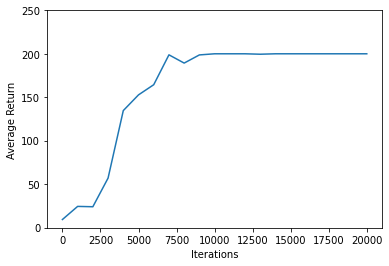

In [31]:
#@test {"skip": true}

iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')
plt.ylim(top=250)

### 動画

グラフは便利ですが、エージェントが環境内で実際にタスクを実行している様子を動画で視覚化するとさらに分かりやすくなります。

まず、ノートブックに動画を埋め込む関数を作成します。

In [32]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

CartPole ゲームのいくつかのエピソードをエージェントで繰り返します。基礎となる Python 環境（TensorFlow 環境ラッパーの「内部」のもの）は、環境の状態のイメージを出力する`render()`メソッドを提供します。これらは動画に収集できます。

In [33]:
def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(eval_py_env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_py_env.render())
  return embed_mp4(filename)




create_policy_eval_video(agent.policy, "trained-agent")

[swscaler @ 0x562893101c00] Warning: data is not aligned! This can lead to a speed loss


トレーニングされたエージェント（上記）をランダムに移動するエージェントと比較してみてください。（ランダムに移動するエージェントは、トレーニングされたエージェントと比べて上手くできません。）

In [34]:
create_policy_eval_video(random_policy, "random-agent")

[swscaler @ 0x55dcc8f6ac00] Warning: data is not aligned! This can lead to a speed loss
